In [1]:
import numpy as np
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import sys
import os
import pathlib
import itertools
import glob
import re

In [2]:
root = pathlib.Path.home()
# pt = os.path.join(root, 'research', 'gen_287_2013_2017_state.csv')
pt = os.path.join(root, 'research', 'GADS_Processed', "trajectories_with_features")

def glob_re(pattern, strings):
    return list(filter(re.compile(pattern).match, strings))

filenames = glob_re(r"gen_\d+_type_200_dtgrp_\d+_rating_\d+_state_Texas_raw.csv", os.listdir(pt))


In [3]:
mylist = []

for f in filenames:
    data = pd.read_csv(os.path.join(pt,f))
    data.set_index(pd.DatetimeIndex(data["x"]), inplace=True)
    data = data[~data.index.duplicated()]
    data.rename(columns={"COAST": "y5", "NORTH_C" : "y5"}, inplace=True)
    mylist.append(data)

In [ ]:
states = mylist[1]["y2"].values

In [ ]:
po_idx = np.where(np.logical_or(states == 3, states == 4))[0]
end_of_event = np.concat([[False], np.diff(po_idx) != 1])
end_of_event_idx = po_idx[end_of_event]

idx = range(len(states))
my_data = np.zeros(len(states))

for i in idx:
    events_before_i = np.array([j for j in end_of_event_idx if j < i])
    if len(events_before_i) > 1:
        closest_idx = np.argmin(i - events_before_i)
        my_event_idx = events_before_i[closest_idx]
        hours_since_event = (i - my_event_idx)
    else:
        hours_since_event = None
    my_data[i] = hours_since_event

In [34]:
df = mylist[1]
df['y6'] = my_data

In [50]:
features = df.loc[(~np.isnan(df["y6"])) & (~np.isnan(df["y5"])), ["y3", "y5", "y4", "y6"]]

In [57]:
states2 = mylist[1]["y2"]

states2 = states2[features.index].values

In [31]:
import sklearn

In [61]:
sklearn.feature_selection.r_regression(features, states2)

array([-0.08855485, -0.12668783,  0.06726015, -0.26414162])

In [60]:
sklearn.feature_selection.chi2(features, states2)

(array([ 108802.91816573,  970923.71596601,   38989.50580933,
        9605001.74915657]),
 array([0., 0., 0., 0.]))

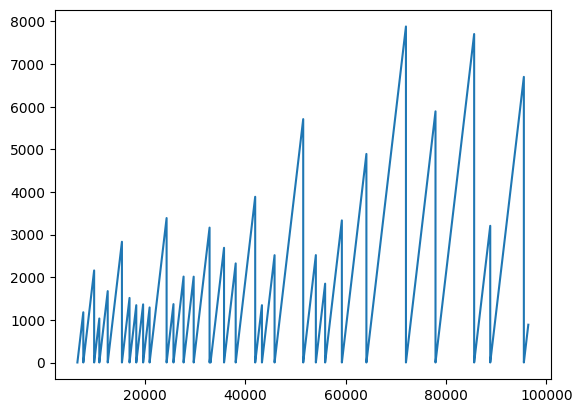

In [30]:
plt.plot(my_data)

<Axes: ylabel='Count'>

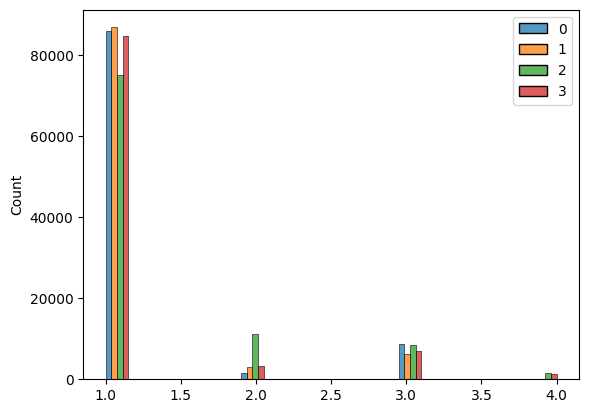

In [56]:
causes = np.vstack([i["y2"].values for i in mylist]).T
fig, ax = plt.subplots()

sns.histplot(causes, ax=ax, multiple="dodge")

,x,y1,y2,y3,y5,y4
x,,,,,,
2013-01-01 06:00:00,2013-01-01T06:00:00.0,1.0,1.0,8766,7050.730776,1
2013-01-01 07:00:00,2013-01-01T07:00:00.0,1.0,1.0,8766,7177.787185,1
2013-01-01 08:00:00,2013-01-01T08:00:00.0,1.0,1.0,8766,7223.212565,1
2013-01-01 09:00:00,2013-01-01T09:00:00.0,1.0,1.0,8766,7314.252182,1
2013-01-01 10:00:00,2013-01-01T10:00:00.0,1.0,1.0,8766,7676.346695,1
...,...,...,...,...,...,...
2023-12-31 20:00:00,2023-12-31T20:00:00.0,1.0,1.0,12783,11918.020000,365
2023-12-31 21:00:00,2023-12-31T21:00:00.0,1.0,1.0,12783,11634.440000,365
2023-12-31 22:00:00,2023-12-31T22:00:00.0,1.0,1.0,12783,11360.100000,365


In [ ]:
df = mylist[3]
# def find_adjacent_index(arr, target1, target2):
#     my_index = []
#     for i in range(len(arr) - 1):
#         if (arr[i] == target1 and arr[i+1] == target2):
#             my_index.append(i)
#     return my_index

# def count_transitions(arr, states):
#     storage = np.zeros((len(states), len(states)))
#     for i, j in itertools.product(states, states):
#         index = find_adjacent_index(arr, i, j)
#         storage[i-1, j-1] = len(index)
#     return storage


# arr3 = count_transitions(df["y2"].values, [1, 2, 3, 4])
# arr3 = arr3/ arr3.sum(axis=1)[:, None]

# states = df["y2"].astype(int).values
# P = np.zeros((4,4))

# for j in range(len(states) - 1):
#     P[states[j] -1, states[j+1] -1] += 1


# P = P / P.sum(axis=1)[:, None]

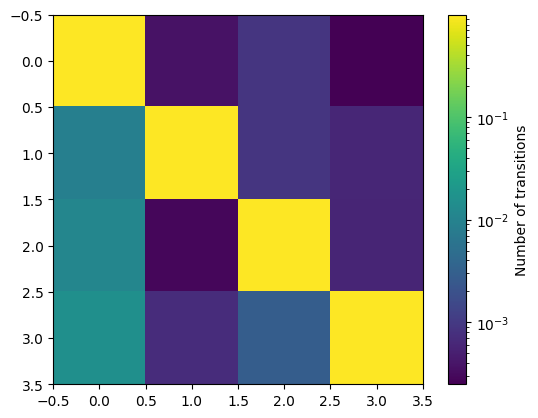

In [117]:
fig, ax = plt.subplots()
im = ax.imshow(P, norm=colors.LogNorm(vmin=np.min(P), vmax=np.max(P)))
fig.colorbar(im, ax=ax, label="Number of transitions")

Text(0.5, 0, 'i + 1 th state')

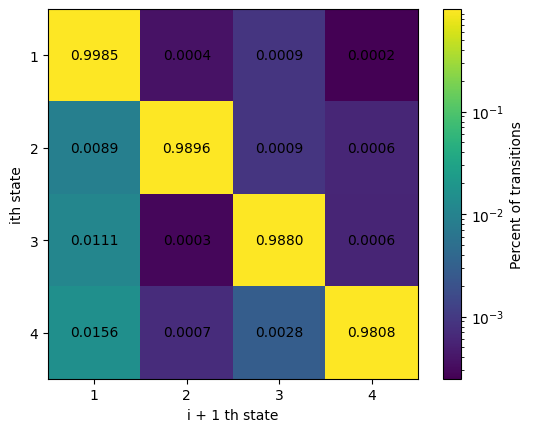

In [119]:
fig, ax = plt.subplots()

im = ax.imshow(arr3, norm=colors.LogNorm(vmin=np.min(arr3), vmax=np.max(arr3)))
x = np.arange(0, 4, 1)
y = np.arange(0, 4, 1)


for i, j in itertools.product(x, y):
    text = ax.text(j, i, f"{arr3[i, j]:.4f}", ha="center", va="center")

fig.colorbar(im, ax=ax, label="Percent of transitions")
ax.set_xticks(range(0, 4, 1), range(1, 5))
ax.set_yticks(range(0, 4, 1), range(1, 5))
ax.set_ylabel("ith state")
ax.set_xlabel("i + 1 th state")

In [44]:
import matplotlib.dates as mdates

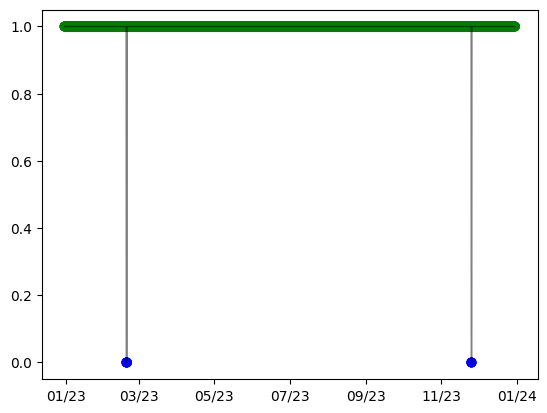

In [69]:
df = mylist[1]
colordict = {1: "g", 2 : "r", 3: "b", 4: "purple"}
i +=1
start_idx = i*8760
end_idx = (i+1)*8760


fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%y'))


myidx = df.index[start_idx:end_idx]
colors = [colordict[c] for c in df.loc[myidx, "y2"]]

ax.plot(myidx, df.loc[myidx, "y1"].values, c='k', lw=1, alpha=0.5)
ax.scatter(myidx, df.loc[myidx, "y1"], alpha=0.5, c=colors)

In [68]:
days_of_year_list = []
for df in mylist:
    vals = df["y4"].values
    daysofyear = vals[np.where(df["y2"] == 3)[0]]

    days_of_year_list.append(daysofyear)

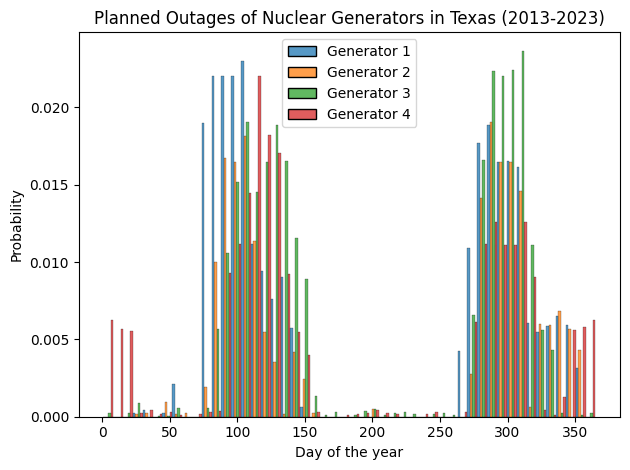

In [ ]:
fig, ax = plt.subplots()

sns.histplot(days_of_year_list, bins=50, ec='k', multiple="dodge", ax=ax, stat="probability")

labels=[f"Generator {i}" for i in range(1,5)]
legend = ax.get_legend()
handles = legend.legend_handles
ax.legend(handles, labels)

ax.set_xlabel("Day of the year")
ax.set_title("Planned Outages of Nuclear Generators in Texas (2013-2023)")
fig.tight_layout();

In [35]:
days_of_year_list = []
for df in mylist:
    vals = df["y4"].values
    daysofyear = vals[np.where(df["y2"] == 4)[0]]

    days_of_year_list.append(daysofyear)

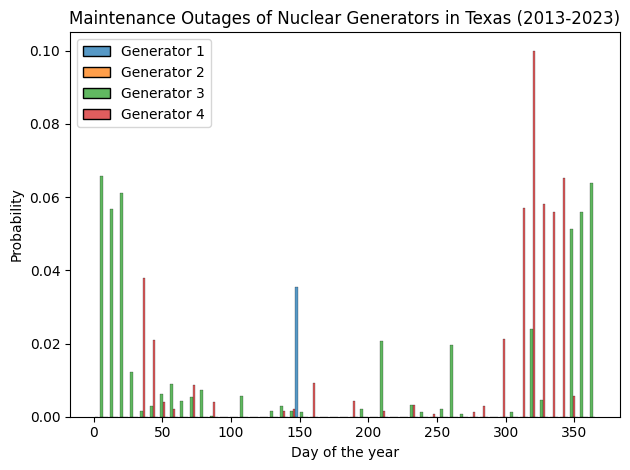

In [36]:
fig, ax = plt.subplots()

sns.histplot(days_of_year_list, bins=50, ec='k', multiple="dodge", ax=ax, stat="probability")

labels=[f"Generator {i}" for i in range(1,5)]
legend = ax.get_legend()
handles = legend.legend_handles
ax.legend(handles, labels)

ax.set_xlabel("Day of the year")
ax.set_title("Maintenance Outages of Nuclear Generators in Texas (2013-2023)")
fig.tight_layout();

In [78]:
days_of_year_list = []
for df in mylist:
    vals = df["y5"].values
    daysofyear = vals[np.where(df["y2"] == 2)[0]]

    days_of_year_list.append(daysofyear)

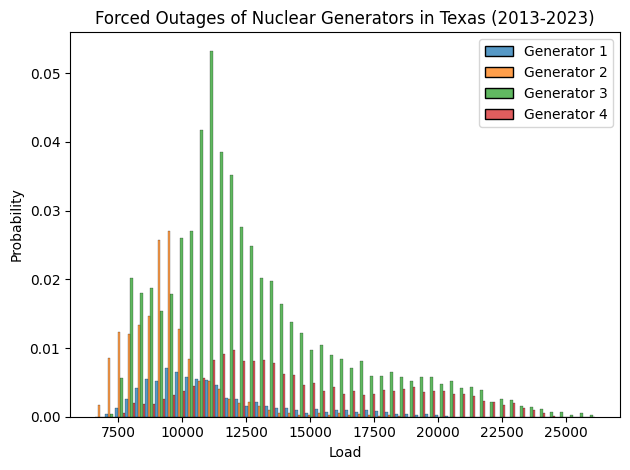

In [44]:
fig, ax = plt.subplots()

sns.histplot(days_of_year_list, bins=50, ec='k', multiple="dodge", ax=ax, stat="probability")

labels=[f"Generator {i}" for i in range(1,5)]
legend = ax.get_legend()
handles = legend.legend_handles
ax.legend(handles, labels)

ax.set_xlabel("Load")
ax.set_title("Forced Outages of Nuclear Generators in Texas (2013-2023)")
fig.tight_layout();

In [ ]:
mysequence = list(itertools.chain.from_iterable(days_of_year_list))
start = np.floor(np.min(np.array(mysequence)))
stop = np.ceil(np.max(np.array(mysequence)))
doy_counts, doy_bins = np.histogram(np.array(mysequence), bins=np.arange(start, stop, 100))

In [81]:
load_list = []
for df in mylist[::2]:
    vals = df["y5"].values

    load_list.append(vals)

In [ ]:
mysequence = list(itertools.chain.from_iterable(load_list))
load_counts, load_bins = np.histogram(np.array(mysequence), bins=np.arange(start, stop, 100))
normalized = doy_counts/load_counts

<BarContainer object of 195 artists>

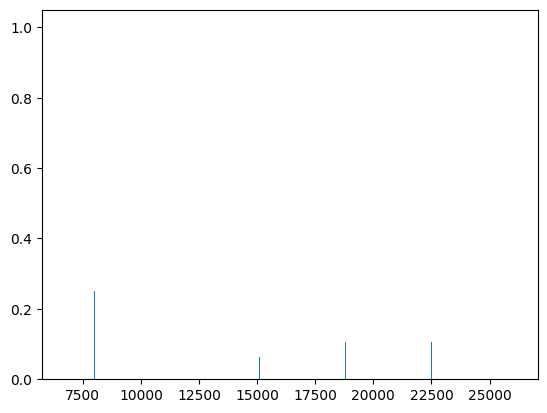

In [85]:
fig, ax = plt.subplots()

ax.bar(doy_bins[1:], normalized)

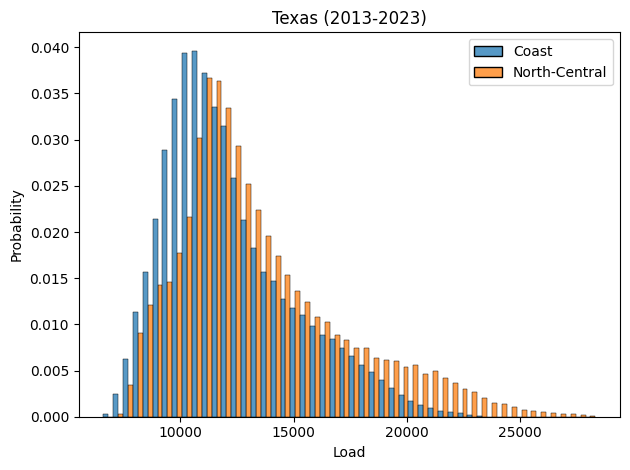

In [53]:
fig, ax = plt.subplots()

sns.histplot(load_list, bins=50, ec='k', multiple="dodge", ax=ax, stat="probability")

labels=["Coast", "North-Central"]
legend = ax.get_legend()
handles = legend.legend_handles
ax.legend(handles, labels)

ax.set_xlabel("Load")
ax.set_title("Texas (2013-2023)")
fig.tight_layout();